In [1]:
import torch.nn as nn
from datetime import date
import time
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

today = str(date.today())

from fast_ml import eda

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn
cudnn.benchmark=True

import mlflow
from mlflow import log_metric, log_param, log_artifacts, start_run, end_run


In [2]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.10.2+cu113
Torchvision Version:  0.11.3+cu113


In [3]:
# MLflow setup

# Artifactory credentials
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://wob-srv-tiho.wob.dos.local:9000/'
os.environ['AWS_ACCESS_KEY_ID'] = 'konstantin'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'konstantin1234'

# MLflow tracking server uri
mlflow.set_tracking_uri("http://wob-srv-tiho.wob.dos.local:5555/")

mlflow.set_experiment('test_km')


<Experiment: artifact_location='s3://mlflow/2', experiment_id='2', lifecycle_stage='active', name='test_km', tags={}>

In [4]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = 'c:/Users/konstantin.moeller/python/ki_in_mrt'

# Models to choose from [resnet, alexnet, vgg16, squeezenet, densenet, inception]
model_name = "resnet50"

# Number of classes in the dataset
# num_classes = 17

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for 
num_epochs = 1

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

#use pretrained models
pre_trained=True

#path to save trained model
save_model = data_dir + '/models/'

#path to save confusion matrix 
save_confusion_mat = data_dir + '/resnet50_mat.csv'

learning_rate=0.1

In [5]:
# Helper
def show_one_image(image, label):
    
    if torch.is_tensor(image):
        plt.imshow(image.permute(1, 2, 0))
    else:
        plt.imshow(image)
    lab = label
    plt.xlabel(lab)
    
def show_batch(dl):
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (20,20))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(torchvision.utils.make_grid(images,nrow=batch_size).permute(1,2,0))
        break

def log_scalar(name, value, step):
    """Log a scalar value to both MLflow and TensorBoard"""
    mlflow.log_metric(name, value, step=step)


In [6]:
df=pd.read_csv('{}/_converted.csv'.format(data_dir))
df['png_file']=df['png_file'].str.replace('.',data_dir, 1, regex=True)

In [7]:
summary_df=eda.df_info(df)

In [8]:
df['scan_art'].value_counts()

T1         43277
T2         14484
T2FLAIR     6388
Name: scan_art, dtype: int64

In [9]:
class_map={'T1':0, 'T2':1, 'T2FLAIR':2}

In [10]:
data=df[['png_file','scan_art']]

In [11]:
data_t1=data[data['scan_art']=='T1'].sample(n=800).reset_index(drop=True)
data_t2=data[data['scan_art']=='T2'].sample(n=800).reset_index(drop=True)
data_t2f=data[data['scan_art']=='T2FLAIR'].sample(n=800).reset_index(drop=True)

In [12]:
train = pd.concat([data_t1[0:600], data_t2[0:600], data_t2f[0:600]], axis=0).sample(frac=1).reset_index(drop=True)
test = pd.concat([data_t1[600:700], data_t2[600:700], data_t2f[600:700]], axis=0).sample(frac=1).reset_index(drop=True)
valid = pd.concat([data_t1[700:], data_t2[700:], data_t2f[700:]], axis=0).sample(frac=1).reset_index(drop=True)

In [13]:
test['scan_art'].value_counts()

T2         100
T1         100
T2FLAIR    100
Name: scan_art, dtype: int64

In [14]:
class dog_brain_data(Dataset):
    def __init__(self, dataframe, transform=transforms.Compose([transforms.Resize((500, 500))])):
        self.dataframe = dataframe
        self.transform = transform
        self.class_map = class_map

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        image = read_image(row[0])
        label = row[1]
        label = self.class_map[label]

        if self.transform:
            image = self.transform(image)

        return image, label

In [15]:
train_data=dog_brain_data(train)
test_data=dog_brain_data(test)
valid_data=dog_brain_data(valid)

In [16]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=0)

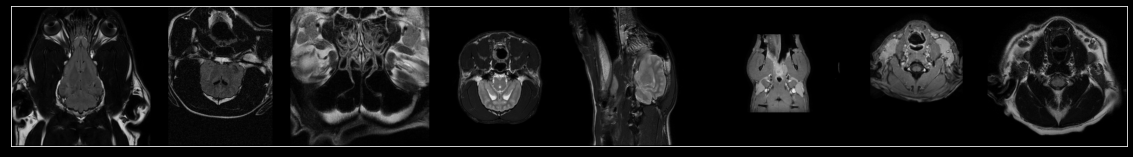

In [17]:
show_batch(train_loader)


In [18]:
def initialize_model(model_name, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet50":
        """ resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, use_pretrained=pre_trained)

# Print the model we just instantiated
# print(model_ft)

In [26]:
print("Initializing Datasets and Dataloaders...")

dataloaders_ft = {'train': train_loader, 'valid': valid_loader}

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

Initializing Datasets and Dataloaders...
cuda:0


In [27]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

In [21]:
model_ft.fc=torch.nn.Sequential(torch.nn.Linear(in_features=2048, out_features=3), torch.nn.Sigmoid())

In [22]:
model_ft.conv1=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [23]:
criterion_ft = torch.nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(model_ft.fc.parameters())
scheduler_ft = torch.optim.lr_scheduler

In [28]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since=time.time()
    val_acc_history = []
        
    best_model_wts=copy.deepcopy(model.state_dict())
    best_acc=0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('_'*10)
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                   
            running_loss=0.0
            running_corrects=0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs=inputs.float().to(device)
                labels=labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):   
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)        
                                        
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss+=loss.item()*inputs.size(0)
                running_corrects+=torch.sum(preds==labels.data)
                
            epoch_loss=running_loss/len(dataloaders[phase].dataset)
            epoch_acc=running_corrects.double()/len(dataloaders[phase].dataset)

            if phase == 'train':
                log_scalar('training_loss', epoch_loss, epoch)
                log_scalar('training_accuracy', float(epoch_acc), epoch)
            if phase == 'valid':
                log_scalar('val_loss', epoch_loss, epoch)
                log_scalar('val_accuracy', float(epoch_acc), epoch)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'valid' and epoch_acc>best_acc:
                best_acc=epoch_acc
                best_model_wts=copy.deepcopy(model.state_dict())
            if phase == 'valid':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    mlflow.log_param('Training time',time_elapsed)
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    mlflow.log_param('Best val Acc',float(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [29]:
mlflow.end_run()

with mlflow.start_run() as run:
    mlflow.log_param('dataset', data_dir)
    mlflow.log_param('model name', model_name)
    mlflow.log_param('batch size', batch_size)
    mlflow.log_param('epochs', num_epochs)
    mlflow.log_param('feature extracted', feature_extract)
    mlflow.log_param('pre-trained', pre_trained)
    mlflow.log_param('initial learning rate', learning_rate)
    # Setup the loss fxn
    # criterion = nn.CrossEntropyLoss()

    # Train and evaluate
    model_ft, hist = train_model(model_ft, dataloaders_ft, criterion_ft, optimizer_ft, num_epochs=num_epochs)
    mlflow.pytorch.log_model(model_ft, "models")
    # mlflow.pytorch.save_model(model_ft, save_model+today+'/')
            


Epoch 1/1
__________
train Loss: 0.9399 Acc: 0.6117
valid Loss: 0.8204 Acc: 0.8267

Training complete in 1m 15s
Best val Acc: 0.826667


2022/06/16 13:33:27 WARNING mlflow.utils.requirements_utils: Found torch version (1.10.2+cu113) contains a local version label (+cu113). MLflow logged a pip requirement for this package as 'torch==1.10.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/06/16 13:33:32 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.11.3+cu113) contains a local version label (+cu113). MLflow logged a pip requirement for this package as 'torchvision==0.11.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [ ]:
# torch.save(model_ft.state_dict(),save_model+model_name+"/"+today+'.pth')

In [30]:
mlflow.end_run()